# Florence-2 Fine-tuning for Visual Question Answering (VQA)

This notebook demonstrates how to fine-tune the Microsoft Florence-2 model on the Visual Question Answering (VQA) v2.0 dataset (Abstract Scenes subset). The process includes:

1. **Data Preparation**: Loading and preprocessing VQA dataset
2. **Exploratory Data Analysis (EDA)**: Analyzing the distribution of questions and answers
3. **Model Fine-tuning**: Training the Florence-2 model on the prepared dataset
4. **Model Export**: Saving the fine-tuned model for deployment

## Setup
The notebook is designed to run in Google Colab with GPU acceleration.

In [ ]:
# Authenticate with Hugging Face
!huggingface-cli login

# IMPORTANT: When prompted, enter your Hugging Face token
# Never store your token in the notebook for security reasons


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

# Note: The dataset should be uploaded to your Google Drive in a ZIP format

!ls /content/drive/MyDrive


 Classroom  'Colab Notebooks'   dataset.zip   Fatter_Final.zip


In [ ]:
!unzip /content/drive/MyDrive/dataset.zip -d /

# List contents of Google Drive to verify access
!ls /content/drive/MyDrive


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/testing/resized testing images/abstract_v002_test2015_000000039783.png  
  inflating: /content/dataset/testing/resized testing images/abstract_v002_test2015_000000045108.png  
  inflating: /content/dataset/testing/resized testing images/abstract_v002_test2015_000000034465.png  
  inflating: /content/dataset/testing/resized testing images/abstract_v002_test2015_000000046846.png  
  inflating: /content/dataset/testing/resized testing images/abstract_v002_test2015_000000044055.png  
  inflating: /content/dataset/testing/resized testing images/abstract_v002_test2015_000000031010.png  
  inflating: /content/dataset/testing/resized testing images/abstract_v002_test2015_000000030233.png  
  inflating: /content/dataset/testing/resized testing images/abstract_v002_test2015_000000045154.png  
  inflating: /content/dataset/testing/resized testing images/abstract_v002_test2015_000000033119.png  
  inflating: /content/

In [ ]:
!ls /content/dataset

# Extract the dataset from the ZIP file
!unzip /content/drive/MyDrive/dataset.zip -d /

# Note: This assumes the dataset is named 'dataset.zip' in your Google Drive


testing  training  validating


creating dataset .JSON file

# Verify the dataset extraction by listing the contents
!ls /content/dataset

In [ ]:
import os
import json
from tqdm import tqdm

# Paths to JSON files for questions and annotations
TRAIN_PATHS = {
    "questions": "/content/dataset/training/questions train/OpenEnded_abstract_v002_train2015_questions.json",
    "annotations": "/content/dataset/training/annotation train/abstract_v002_train2015_annotations.json",
}
VALIDATE_PATHS = {
    "questions": "/content/dataset/validating/questions validate/OpenEnded_abstract_v002_val2015_questions.json",
    "annotations": "/content/dataset/validating/annotation validate/abstract_v002_val2015_annotations.json",
}
TEST_PATH = "/content/dataset/testing/questions test/OpenEnded_abstract_v002_test2015_questions.json"

# Paths to save the generated dataset JSON files
OUTPUT_PATHS = {
    "train": "/content/dataset/training/open_ended_train.json",
    "val": "/content/dataset/validating/open_ended_val.json",
    "test": "/content/dataset/testing/open_ended_test.json",
}

## Data Preprocessing: Creating JSON Files for Training

# In this section, we'll create structured JSON files from the raw VQA dataset files. The preprocessing includes:
# 1. Loading question and annotation files
# 2. Matching questions with their corresponding answers
# 3. Creating standardized data records with image paths, questions, and answers

# Function to generate a dataset for training and validating
def generate_dataset(questions_path, annotations_path, image_dir, output_path, is_test=False):
    # Load the questions JSON
    with open(questions_path, "r") as f:
        questions_data = json.load(f)["questions"]  # Assuming key 'questions'

    # Load the annotations JSON (not used for test data)
    if not is_test:
        with open(annotations_path, "r") as f:
            annotations_data = {ann["question_id"]: ann for ann in json.load(f)["annotations"]}

    # Generate dataset
    dataset = []
    for question in tqdm(questions_data, desc=f"Processing {questions_path}"):
        question_id = question["question_id"]
        image_id = question["image_id"]
        question_text = question["question"]
        image_filename = f"abstract_v002_train2015_{image_id:012d}.png" if "train2015" in questions_path else f"abstract_v002_val2015_{image_id:012d}.png"
        image_path = os.path.join(image_dir, image_filename)

        # To find the corresponding open-ended answer for training and validation,
        if not is_test:
            annotation = annotations_data.get(question_id)
            if annotation:
                # Use the open-ended answers
                open_ended_answers = annotation["answers"]
                # Combine all possible answers into one
                answers_dict = {}
                for ans in open_ended_answers:
                    answers_dict[ans["answer"]] = answers_dict.get(ans["answer"], 0) + 1
                most_common_answer = max(answers_dict, key=answers_dict.get)
            else:
                most_common_answer = "No answer found"

            dataset.append({
                "image": image_path,
                "question": f"<VQA> {question_text}",
                "answer": most_common_answer,
            })
        else:
            # For test data, there's no answer
            dataset.append({
                "image": image_path,
                "question": f"<VQA> {question_text}",
                "answer": "No answer",  # Placeholder for testing
            })

    # Save the dataset to JSON
    with open(output_path, "w") as f:
        json.dump(dataset, f, indent=4)
    print(f"[INFO] Dataset saved to {output_path}")

# Generate training dataset
generate_dataset(
    questions_path=TRAIN_PATHS["questions"],
    annotations_path=TRAIN_PATHS["annotations"],
    image_dir="/content/dataset/training/resized training images",
    output_path=OUTPUT_PATHS["train"],
)

# Generate validation dataset
generate_dataset(
    questions_path=VALIDATE_PATHS["questions"],
    annotations_path=VALIDATE_PATHS["annotations"],
    image_dir="/content/dataset/validating/resized validating images",
    output_path=OUTPUT_PATHS["val"],
)

# Generate test dataset
generate_dataset(
    questions_path=TEST_PATH,
    annotations_path=None,  # No annotations for test
    image_dir="/content/dataset/testing/resized testing images",
    output_path=OUTPUT_PATHS["test"],
    is_test=True,
)


Processing /content/dataset/training/questions train/OpenEnded_abstract_v002_train2015_questions.json: 100%|██████████| 60000/60000 [00:00<00:00, 107363.92it/s]


[INFO] Dataset saved to /content/dataset/training/open_ended_train.json


Processing /content/dataset/validating/questions validate/OpenEnded_abstract_v002_val2015_questions.json: 100%|██████████| 30000/30000 [00:00<00:00, 174435.12it/s]


[INFO] Dataset saved to /content/dataset/validating/open_ended_val.json


Processing /content/dataset/testing/questions test/OpenEnded_abstract_v002_test2015_questions.json: 100%|██████████| 60000/60000 [00:00<00:00, 460176.75it/s]


[INFO] Dataset saved to /content/dataset/testing/open_ended_test.json


EDA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== Analyzing Training dataset ===


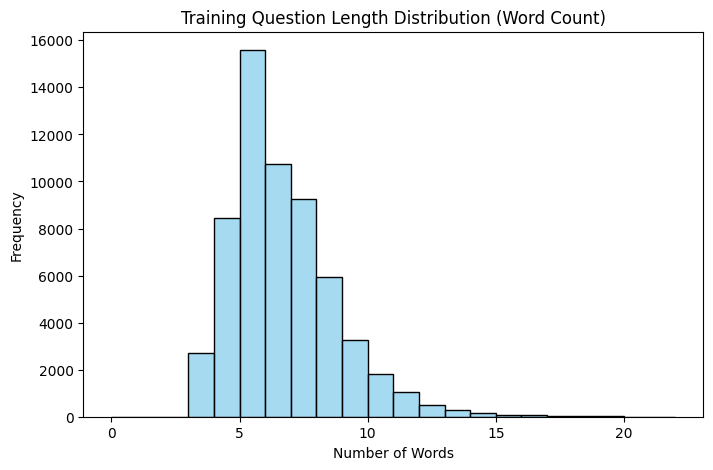

<ipython-input-30-491e36e979cf>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


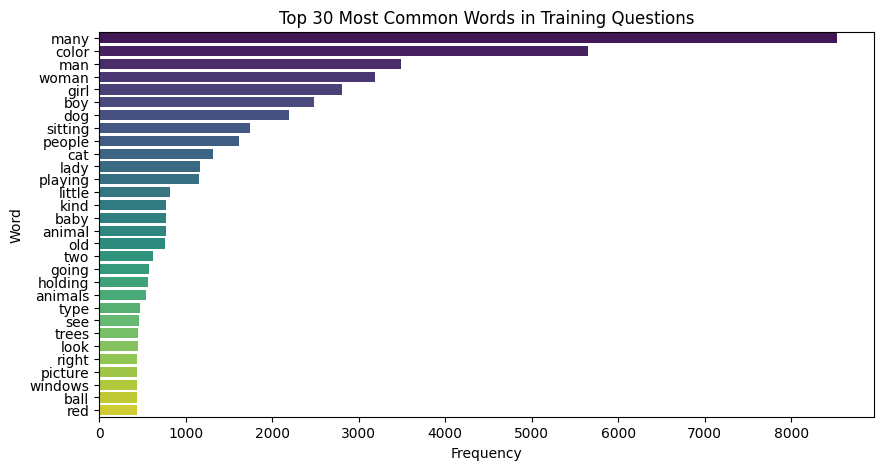

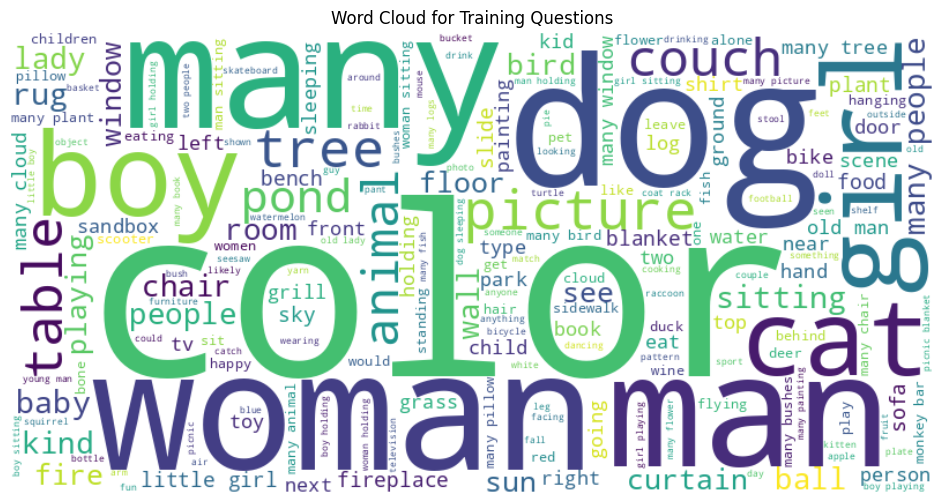

Training Total Unique Answers: 2514


<ipython-input-30-491e36e979cf>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(answer_counts), y=list(answers), palette='magma')


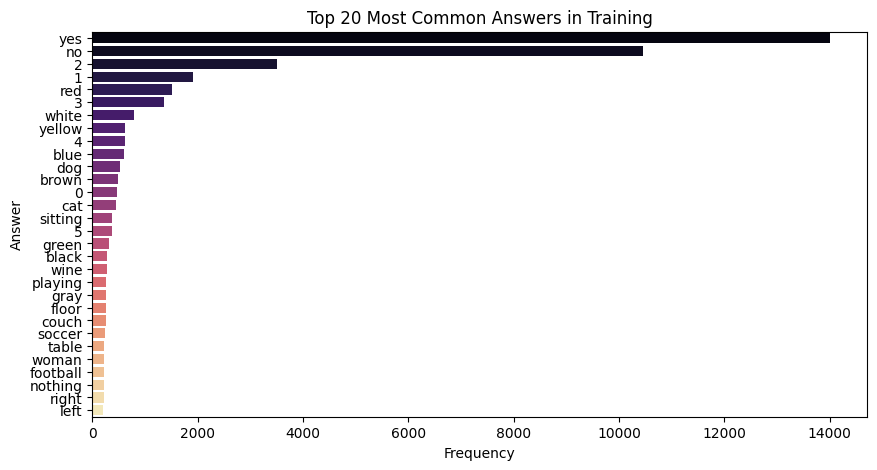

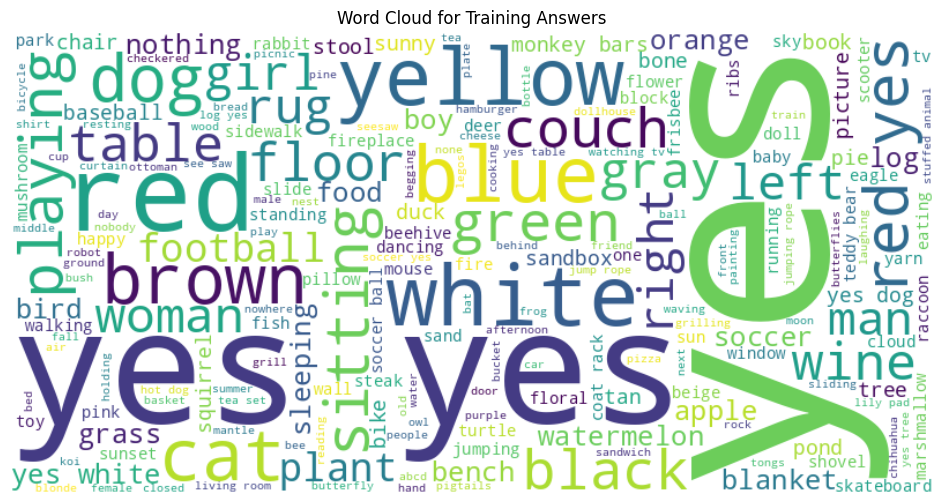


=== Analyzing Validation dataset ===


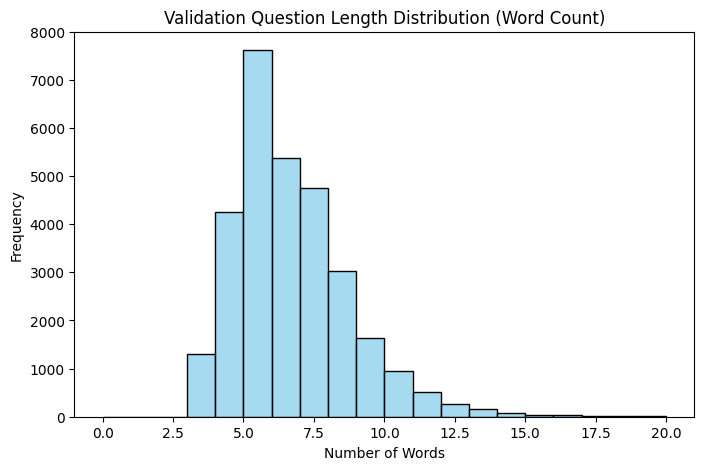

<ipython-input-30-491e36e979cf>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


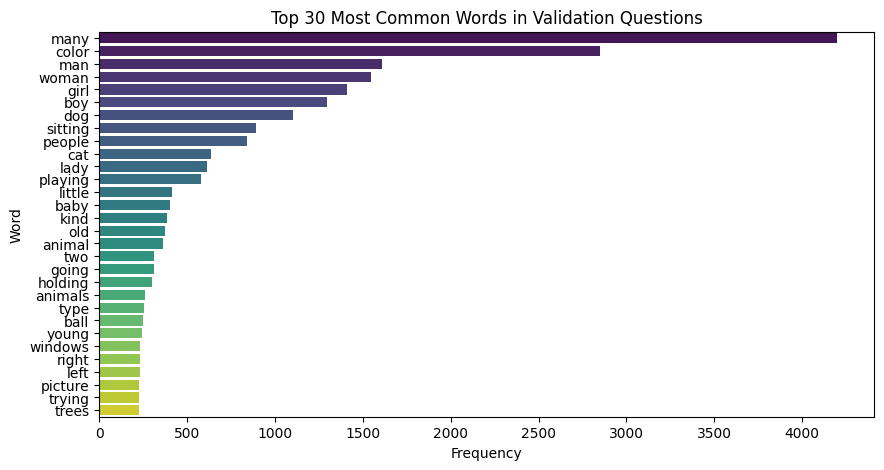

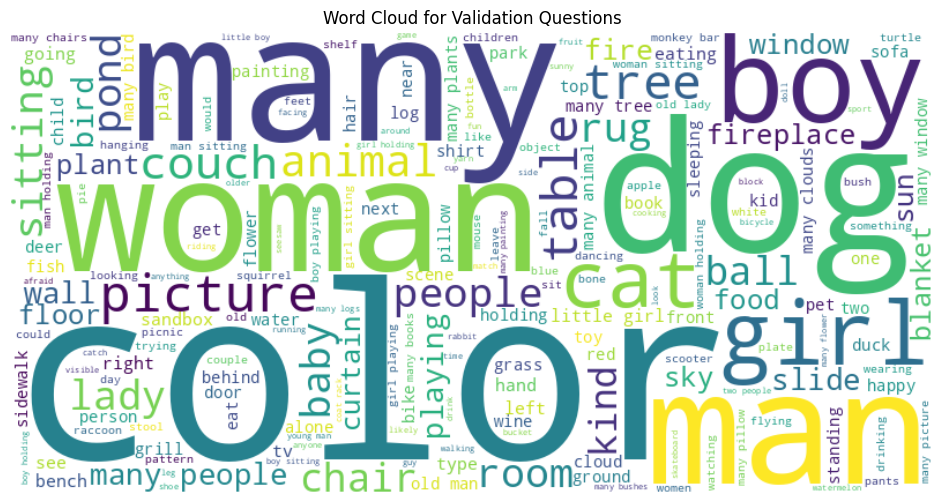

Validation Total Unique Answers: 1583


<ipython-input-30-491e36e979cf>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(answer_counts), y=list(answers), palette='magma')


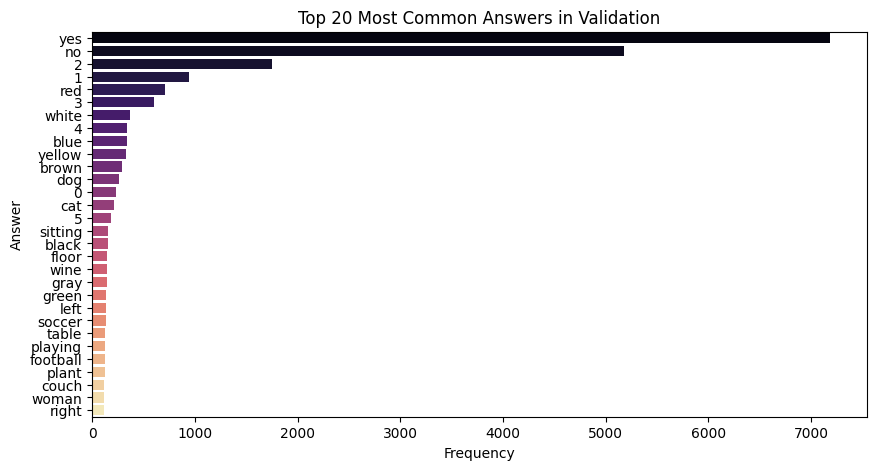

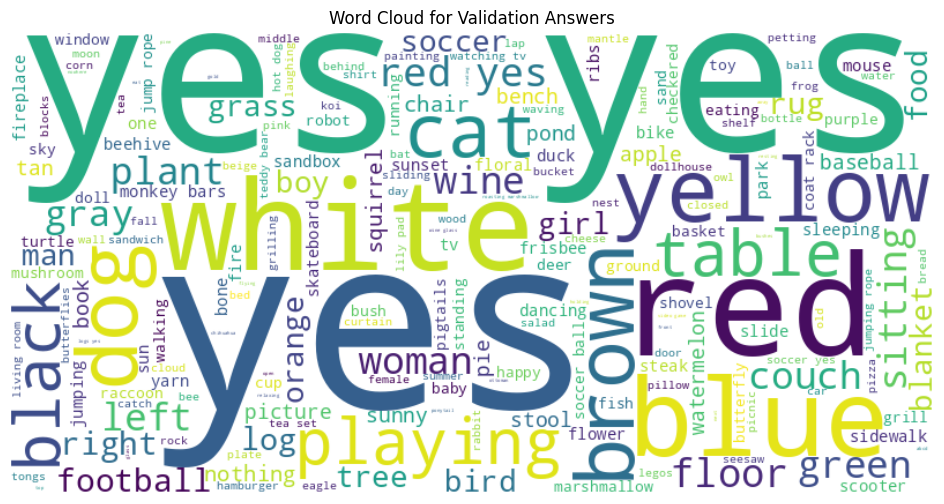


=== Analyzing Testing dataset ===


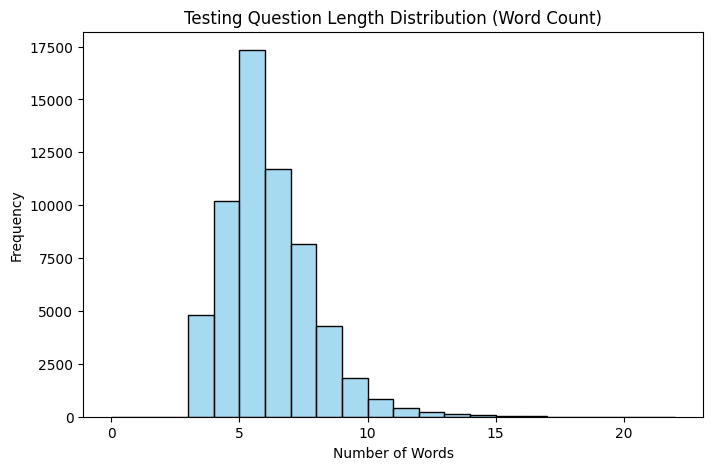

<ipython-input-30-491e36e979cf>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


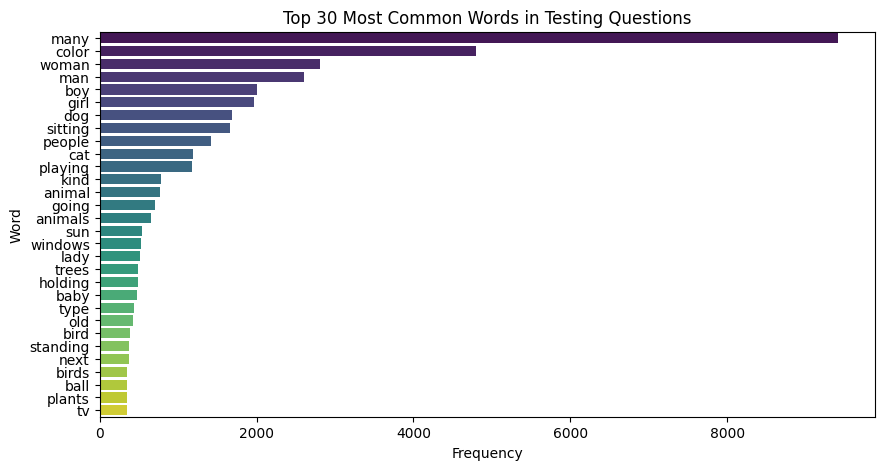

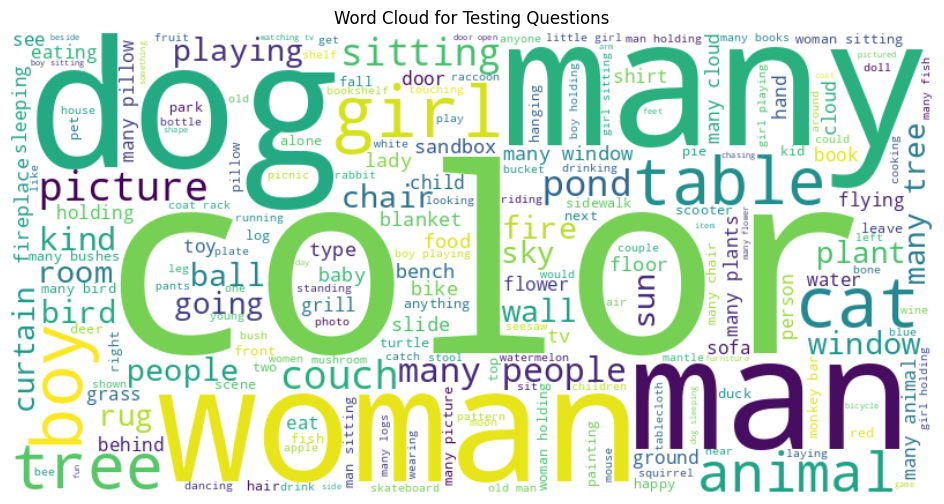

Testing dataset answers are not informative. Skipping answer EDA.


In [ ]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from PIL import Image
import os
import numpy as np

# Download NLTK stopwords if not already present
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def eda_for_dataset(json_file, dataset_name, sample_size=50):
    print(f"\n=== Analyzing {dataset_name} dataset ===")

    # Load JSON data
    with open(json_file, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)

    # Clean the question text by removing the "<VQA>" prefix and extra whitespace
    df['clean_question'] = df['question'].str.replace('<VQA>', '', regex=False).str.strip()
    # Compute word count for each question
    df['question_word_count'] = df['clean_question'].apply(lambda x: len(x.split()))

    # ---------------------------
    # Exploratory Data Analysis (EDA)
    # ---------------------------
    # 1. Histogram of question lengths (word counts)
    plt.figure(figsize=(8, 5))
    sns.histplot(df['question_word_count'], bins=range(0, df['question_word_count'].max() + 2), kde=False, color='skyblue')
    plt.title(f'{dataset_name} Question Length Distribution (Word Count)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

    # 2. Word frequency analysis for questions
    all_questions_text = " ".join(df['clean_question'].tolist()).lower()
    question_tokens = [word for word in all_questions_text.split() if word.isalpha() and word not in stop_words]
    question_word_freq = Counter(question_tokens)
    most_common_q_words = question_word_freq.most_common(30)

    # Bar chart for top 30 words in questions
    words, counts = zip(*most_common_q_words[:30])
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top 30 Most Common Words in {dataset_name} Questions')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

    # Word cloud for questions
    question_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(all_questions_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(question_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {dataset_name} Questions')
    plt.show()

    # ---------------------------
    # EDA for Answers (if available and informative)
    # ---------------------------
    if 'answer' in df.columns:
        # Clean the answer text (lowercase, strip)
        df['clean_answer'] = df['answer'].str.lower().str.strip()
        # If this is the testing dataset or if answers are not informative, skip answer EDA.
        unique_answers = set(df['clean_answer'].unique())
        if dataset_name.lower() == "testing" or unique_answers == {"no answer"}:
            print(f"{dataset_name} dataset answers are not informative. Skipping answer EDA.")
        else:
            answer_freq = Counter(df['clean_answer'])
            num_unique_answers = len(answer_freq)
            print(f"{dataset_name} Total Unique Answers: {num_unique_answers}")

            # Bar chart for top 20 answers
            most_common_answers = answer_freq.most_common(30)
            answers, answer_counts = zip(*most_common_answers)
            plt.figure(figsize=(10, 5))
            sns.barplot(x=list(answer_counts), y=list(answers), palette='magma')
            plt.title(f'Top 20 Most Common Answers in {dataset_name}')
            plt.xlabel('Frequency')
            plt.ylabel('Answer')
            plt.show()

            # Word cloud for answers
            all_answers_text = " ".join(df['clean_answer'].tolist())
            answer_wc = WordCloud(width=800, height=400, background_color='white').generate(all_answers_text)
            plt.figure(figsize=(12, 6))
            plt.imshow(answer_wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud for {dataset_name} Answers')
            plt.show()
    else:
        print(f"{dataset_name} dataset does not contain answers. Skipping answer EDA.")



# Define file paths for each dataset (update these paths as needed)
train_json = '/content/dataset/training/open_ended_train.json'
val_json = '/content/dataset/validating/open_ended_val.json'
test_json = '/content/dataset/testing/open_ended_test.json'

# Run EDA for each dataset separately
eda_for_dataset(train_json, 'Training')
eda_for_dataset(val_json, 'Validation')
eda_for_dataset(test_json, 'Testing')


fine tuning the model

In [ ]:
import os
import json
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoProcessor, AdamW, get_scheduler
from tqdm import tqdm
from PIL import Image
import torch
import torch.multiprocessing as mp  # Import torch.multiprocessing

# Paths
BASE_DIR = "/content/dataset"
JSON_PATHS = {
    "train": os.path.join(BASE_DIR, "training/open_ended_train.json"),
    "val": os.path.join(BASE_DIR, "validating/open_ended_val.json"),
}
BATCH_SIZE = 8  # Optimized for A100 GPU
EPOCHS = 3
LEARNING_RATE = 1e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Class
class VQADataset(Dataset):
    def __init__(self, json_path, processor):
        self.data = json.load(open(json_path))
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = example["question"]
        answer = example["answer"]
        image_path = example["image"]

        # Check if image exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        return question, answer, image

# Data Collector
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(
        text=list(questions),
        images=list(images),
        return_tensors="pt",
        padding=True,
    ).to(DEVICE)
    return inputs, answers

# Load Datasets
def load_datasets(processor):
    train_dataset = VQADataset(JSON_PATHS["train"], processor)
    val_dataset = VQADataset(JSON_PATHS["val"], processor)
    return train_dataset, val_dataset

# Debugging Function
def debug_dataset(dataset, num_samples=5):
    print("[INFO] Debugging Dataset:")
    for i in range(num_samples):
        question, answer, image = dataset[i]
        print(f"Sample {i+1}:")
        print(f"  Question: {question}")
        print(f"  Answer: {answer}")
        print(f"  Image Size: {image.size}")

# Training Loop
def train_model(model, processor, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            inputs, answers = batch
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False,
            ).input_ids.to(DEVICE)

            outputs = model(
                input_ids=inputs["input_ids"],
                pixel_values=inputs["pixel_values"],
                labels=labels,
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False,
                ).input_ids.to(DEVICE)

                outputs = model(
                    input_ids=inputs["input_ids"],
                    pixel_values=inputs["pixel_values"],
                    labels=labels,
                )
                val_loss += outputs.loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"/content/florence2_checkpoint_epoch_{epoch + 1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

    # Final Save
    final_dir = "/content/florence2_finetuned_model"
    os.makedirs(final_dir, exist_ok=True)
    model.save_pretrained(final_dir)
    processor.save_pretrained(final_dir)
    print(f"[INFO] Model fine-tuned and saved at {final_dir}")

    return final_dir

# Execution
if __name__ == "__main__":
    # Set the start method to 'spawn' before creating DataLoader
    mp.set_start_method("spawn", force=True)

    # Load Model and Processor
    processor = AutoProcessor.from_pretrained(
        "microsoft/Florence-2-base-ft",
        trust_remote_code=True,
        revision="refs/pr/6",
    )
    model = AutoModelForCausalLM.from_pretrained(
        "microsoft/Florence-2-base-ft",
        trust_remote_code=True,
        revision="refs/pr/6",
    ).to(DEVICE)

    # Load datasets
    train_dataset, val_dataset = load_datasets(processor)

    # Debug dataset samples
    debug_dataset(train_dataset)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0, shuffle=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0
    )

    # Train the model
    fine_tuned_model_path = train_model(model, processor, train_loader, val_loader)

    # Display instructions for downloading the fine-tuned model
    print("\n[INFO] Training complete.")
    print(f"Download your fine-tuned model from: {fine_tuned_model_path}")
    print(f"To download, use the Colab file browser and locate the folder: {fine_tuned_model_path}")

## Model Fine-tuning

This section implements the fine-tuning process for the Florence-2 model:
- Creating a custom PyTorch Dataset for VQA
- Setting up the training and validation data loaders
- Implementing the training loop with optimization
- Checkpointing and saving the model


[INFO] Debugging Dataset:
Sample 1:
  Question: <VQA> Who looks happier?
  Answer: man
  Image Size: (224, 224)
Sample 2:
  Question: <VQA> Where is the woman sitting?
  Answer: blanket
  Image Size: (224, 224)
Sample 3:
  Question: <VQA> Where is the man sitting?
  Answer: bench
  Image Size: (224, 224)
Sample 4:
  Question: <VQA> Is this man hungry?
  Answer: yes
  Image Size: (224, 224)
Sample 5:
  Question: <VQA> What kind of drink is that?
  Answer: soda
  Image Size: (224, 224)


Training Epoch 1/3: 100%|██████████| 7500/7500 [2:33:20<00:00,  1.23s/it]


Average Training Loss: 0.3070036208311096


Validation Epoch 1/3: 100%|██████████| 3750/3750 [34:36<00:00,  1.81it/s]


Average Validation Loss: 0.23985547591845194


Training Epoch 2/3: 100%|██████████| 7500/7500 [2:30:56<00:00,  1.21s/it]


Average Training Loss: 0.17578595761911323


Validation Epoch 2/3: 100%|██████████| 3750/3750 [33:15<00:00,  1.88it/s]


Average Validation Loss: 0.20605275586095328


Training Epoch 3/3: 100%|██████████| 7500/7500 [2:29:40<00:00,  1.20s/it]


Average Training Loss: 0.11143303689092088


Validation Epoch 3/3: 100%|██████████| 3750/3750 [33:09<00:00,  1.88it/s]


Average Validation Loss: 0.20182399651769858
[INFO] Model fine-tuned and saved at /content/florence2_finetuned_model

[INFO] Training complete.
Download your fine-tuned model from: /content/florence2_finetuned_model
To download, use the Colab file browser and locate the folder: /content/florence2_finetuned_model


In [ ]:
import shutil

# Path to the fine-tuned model
model_path = "/content/florence2_checkpoint_epoch_2"

# Compress the model folder into a zip file
shutil.make_archive("florence2_checkpoint_epoch_3", "zip", model_path)




'/content/florence2_checkpoint_epoch_3.zip'

In [ ]:
model.save_pretrained("./model")
processor.save_pretrained("./model")

# Archive a specific checkpoint for backup
import shutil

# Path to the checkpoint model (epoch 2)
model_path = "/content/florence2_checkpoint_epoch_2"

# Compress the model folder into a zip file for easier download
shutil.make_archive("florence2_checkpoint_epoch_3", "zip", model_path)
print("Model checkpoint archived successfully!")


[]

In [ ]:
# Create a ZIP archive of the final model for download
import shutil

# Path to the final model
model_path = "/content/model"

# Compress the model folder into a zip file
shutil.make_archive("model", "zip", model_path)
print("Model compressed and ready for download")

# Download the model ZIP file to your local machine



print("Download initiated - check your browser's downloads folder")files.download("model.zip")from google.colab import files
# Save the final model and processor to the './model' directory
# This creates a separate copy that can be downloaded
model.save_pretrained("./model")
processor.save_pretrained("./model")
print("Final model and processor saved to './model' directory")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

We have successfully:
1. Preprocessed the VQA v2.0 dataset (Abstract Scenes)
2. Performed exploratory data analysis to understand the dataset characteristics
3. Fine-tuned the Florence-2 model for the VQA task
4. Saved and exported the model for deployment in a web application

The fine-tuned model is ready to be used in the Streamlit web application to answer questions about images.